In [8]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    classification_report
)



In [9]:
# ------------------ 1) Load dataset ------------------
path = "C:\\Users\\deepa\\OneDrive\\Desktop\\practice\\PROJECTS\\Credit-Card Fraud\\creditcard_2023.csv"

df = pd.read_csv(path)

In [10]:
# ------------------ 2) Detect target column ------------------
# Preferred names
preferred_names = ['Class', 'class', 'Fraud', 'fraud', 'isFraud', 'IsFraud', 'target', 'Target', 'label', 'Label', 'y']

target_col = None
for name in preferred_names:
    if name in df.columns:
        target_col = name
        break



In [11]:
# If not found by name, try to infer a binary target column
def find_binary_target(dataframe):
    # candidate binary columns
    binary_cols = []
    for col in dataframe.columns:
        unique_vals = dataframe[col].dropna().unique()
        if len(unique_vals) == 2:
            # numeric or boolean preferred
            if pd.api.types.is_numeric_dtype(dataframe[col]) or pd.api.types.is_bool_dtype(dataframe[col]):
                binary_cols.append(col)
    if not binary_cols:
        return None
    # pick the most imbalanced binary column (fraud tends to be minority)
    best_col, best_ratio = None, 1.0
    for col in binary_cols:
        val_counts = dataframe[col].value_counts(normalize=True, dropna=True)
        # minority class proportion
        minority = val_counts.min()
        if minority < best_ratio:
            best_ratio = minority
            best_col = col
    return best_col

if target_col is None:
    target_col = find_binary_target(df)

if target_col is None:
    raise ValueError(
        "Could not automatically detect a binary target column. "
        f"Available columns: {list(df.columns)}. "
        "Please rename your label to one of "
        "['Class','Fraud','isFraud','target','label','y'] or provide a binary label column."
    )



In [12]:
# ------------------ Basic info for user ------------------
report_lines = []
report_lines.append(f"Detected target column: {target_col}")



In [13]:
# Handle categorical/non-numeric features (one-hot encode)
# Exclude the target from dummies
X_df = df.drop(columns=[target_col])
y = df[target_col]



In [14]:
# Fill any missing values before encoding
# For numeric columns: fill with median; for object columns: fill with most frequent
for col in X_df.columns:
    if pd.api.types.is_numeric_dtype(X_df[col]):
        X_df[col] = X_df[col].fillna(X_df[col].median())
    else:
        X_df[col] = X_df[col].fillna(X_df[col].mode().iloc[0] if not X_df[col].mode().empty else "missing")



In [15]:
# One-hot encode non-numeric
X_df = pd.get_dummies(X_df, drop_first=True)



In [16]:
# Ensure y is numeric binary {0,1}
if pd.api.types.is_bool_dtype(y):
    y = y.astype(int)
# If labels are strings like 'fraud'/'legit', map to 1/0 by minority class heuristic
if not pd.api.types.is_numeric_dtype(y):
    # map unique labels to integers with minority -> 1
    vc = y.value_counts()
    if len(vc) == 2:
        labels_sorted = vc.index.tolist()
        # minority label becomes 1
        mapping = {labels_sorted[0]: 0, labels_sorted[1]: 1}
        if vc.iloc[0] > vc.iloc[1]:
            # swap so minority gets 1
            mapping = {labels_sorted[0]: 0, labels_sorted[1]: 1}
        else:
            mapping = {labels_sorted[0]: 1, labels_sorted[1]: 0}
        y = y.map(mapping)
    else:
        # Not binary after all
        raise ValueError(f"Target column '{target_col}' is not binary. Unique values: {y.unique()}")



In [17]:
# Verify binary 0/1
unique_y = sorted(pd.Series(y.unique()).dropna().tolist())
if not (len(unique_y) == 2 and set(unique_y) == {0, 1}):
    raise ValueError(f"Target column '{target_col}' is not binary 0/1 after processing. Found: {unique_y}")



In [18]:
# Class balance summary
class_counts = pd.Series(y).value_counts()
report_lines.append("Class distribution:\n" + str(class_counts))



In [19]:
# ------------------ 3) Train/Test split ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_df.values, y.values, test_size=0.2, random_state=42, stratify=y.values
)



In [20]:
# ------------------ 4) Scale + LDA ------------------
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)



,solver,'svd'
,shrinkage,None
,priors,None
,n_components,None
,store_covariance,False
,tol,0.0001
,covariance_estimator,None


In [21]:
# ------------------ 5) Metrics ------------------
# Train predictions
y_train_pred = lda.predict(X_train_scaled)
y_train_proba = lda.predict_proba(X_train_scaled)[:, 1]
train_acc = accuracy_score(y_train, y_train_pred)
train_cm = confusion_matrix(y_train, y_train_pred)

# Test predictions
y_test_pred = lda.predict(X_test_scaled)
y_test_proba = lda.predict_proba(X_test_scaled)[:, 1]
test_acc = accuracy_score(y_test, y_test_pred)
test_cm = confusion_matrix(y_test, y_test_pred)



In [22]:
# ROC-AUC (optional but useful)
try:
    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)
except Exception as e:
    train_auc = np.nan
    test_auc = np.nan

report_lines.append(f"Train Accuracy: {train_acc:.4f}")
report_lines.append(f"Test Accuracy: {test_acc:.4f}")
if not np.isnan(train_auc):
    report_lines.append(f"Train ROC-AUC: {train_auc:.4f}")
if not np.isnan(test_auc):
    report_lines.append(f"Test ROC-AUC: {test_auc:.4f}")
report_lines.append("Train Confusion Matrix:\n" + str(train_cm))
report_lines.append("Test Confusion Matrix:\n" + str(test_cm))
report_lines.append("Classification Report (Test):\n" + classification_report(y_test, y_test_pred, digits=4))

metrics_text = "\n\n".join(report_lines)



In [24]:
# Save report
import os

output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)  # create folder if it doesn't exist
report_path = os.path.join(output_dir, "lda_fraud_report.txt")

with open(report_path, "w") as f:
    f.write(metrics_text)



In [25]:
# ------------------ 6) Visualizations ------------------
# Function to plot and save confusion matrix
def plot_confusion_matrix(cm, title, filename):
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.tight_layout()
    fig.savefig(filename, bbox_inches='tight')
    plt.show()



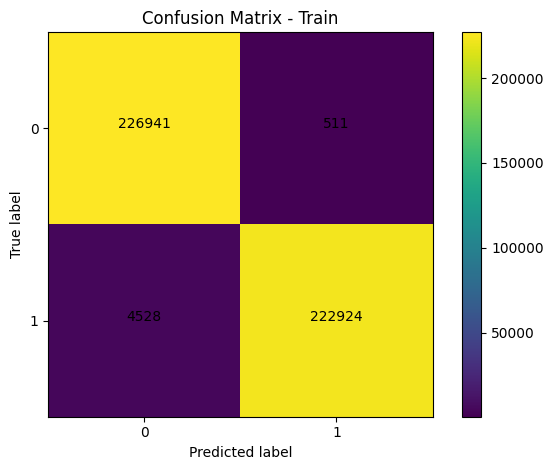

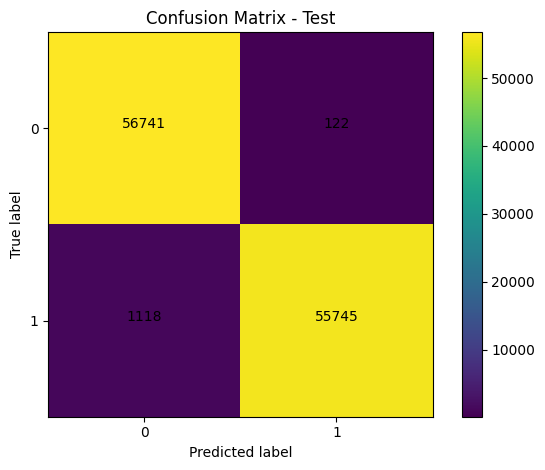

In [27]:
# Train CM
plot_confusion_matrix(train_cm, "Confusion Matrix - Train", os.path.join(output_dir, "cm_train.png"))

# Test CM
plot_confusion_matrix(test_cm, "Confusion Matrix - Test", os.path.join(output_dir, "cm_test.png"))



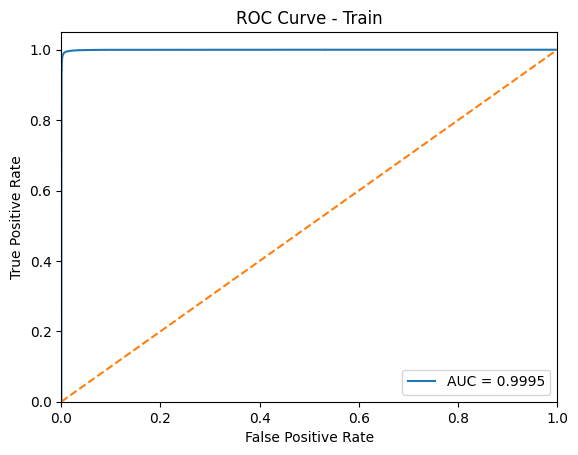

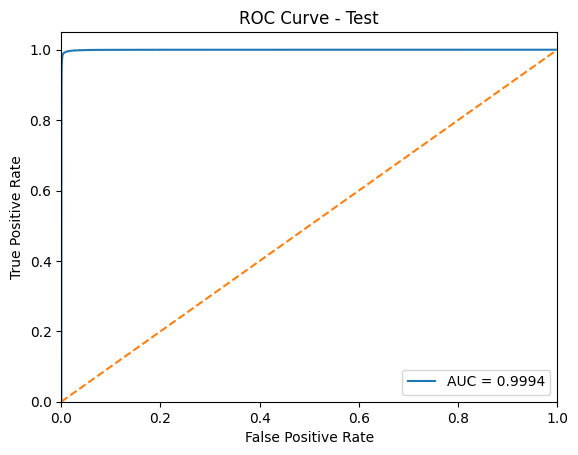

In [30]:
# ROC Curves for Train and Test
def plot_roc(fpr, tpr, auc_val, title, filename):
    fig = plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.4f}" if not np.isnan(auc_val) else "AUC = N/A")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    fig.savefig(filename, bbox_inches='tight')
    plt.show()

fpr_tr, tpr_tr, _ = roc_curve(y_train, y_train_proba)
fpr_te, tpr_te, _ = roc_curve(y_test, y_test_proba)
plot_roc(fpr_tr, tpr_tr, train_auc, "ROC Curve - Train", "outputs\\roc_train.png")
plot_roc(fpr_te, tpr_te, test_auc, "ROC Curve - Test", "outputs\\roc_test.png")



In [31]:
# LDA scores distribution (1D) for Train and Test
def plot_lda_scores(scores, labels, title, filename):
    fig = plt.figure()
    # Plot histograms for each class
    scores0 = scores[labels == 0]
    scores1 = scores[labels == 1]
    plt.hist(scores0, bins=50, alpha=0.7, label='Class 0')
    plt.hist(scores1, bins=50, alpha=0.7, label='Class 1')
    plt.title(title)
    plt.xlabel('LDA Score')
    plt.ylabel('Frequency')
    plt.legend()
    fig.savefig(filename, bbox_inches='tight')
    plt.show()



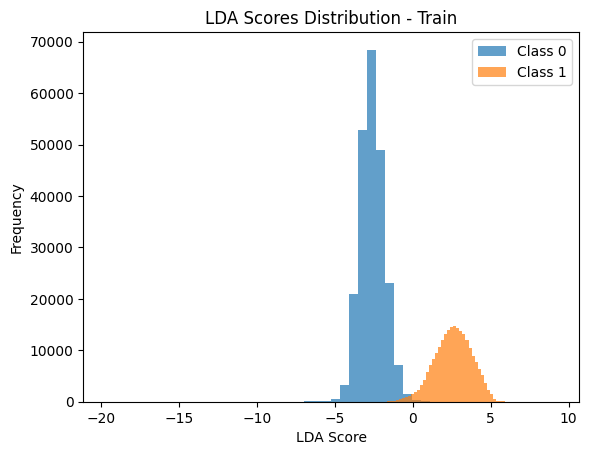

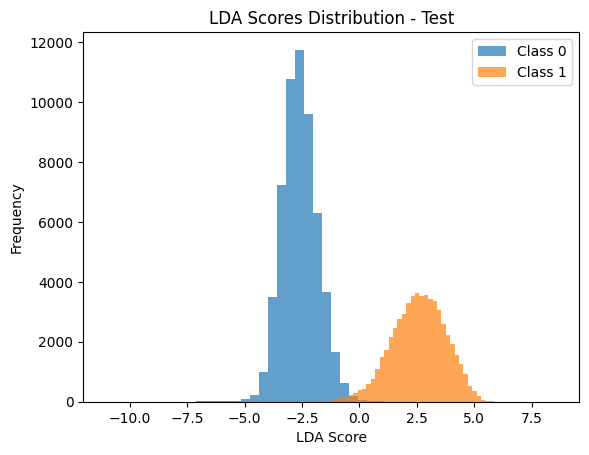

In [33]:
# LDA transform gives 1D for binary classification
train_scores = lda.transform(X_train_scaled).ravel()
test_scores = lda.transform(X_test_scaled).ravel()
plot_lda_scores(train_scores, y_train, "LDA Scores Distribution - Train",
                os.path.join(output_dir, "lda_scores_train.png"))

plot_lda_scores(test_scores, y_test, "LDA Scores Distribution - Test",
                os.path.join(output_dir, "lda_scores_test.png"))




In [34]:
# Display a concise metrics summary for the user
print(metrics_text)



Detected target column: Class

Class distribution:
Class
0    284315
1    284315
Name: count, dtype: int64

Train Accuracy: 0.9889

Test Accuracy: 0.9891

Train ROC-AUC: 0.9995

Test ROC-AUC: 0.9994

Train Confusion Matrix:
[[226941    511]
 [  4528 222924]]

Test Confusion Matrix:
[[56741   122]
 [ 1118 55745]]

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9807    0.9979    0.9892     56863
           1     0.9978    0.9803    0.9890     56863

    accuracy                         0.9891    113726
   macro avg     0.9892    0.9891    0.9891    113726
weighted avg     0.9892    0.9891    0.9891    113726



In [38]:
# If the dataset isn't too large, show the first few rows
display_sample = df.head(10)
print("Sample of Loaded Data (first 10 rows):")
print(display_sample)


Sample of Loaded Data (first 10 rows):
   id        V1        V2        V3        V4        V5        V6        V7  \
0   0 -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898  0.519014   
1   1  0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605  0.406466   
2   2 -0.260272 -0.949385  1.728538 -0.457986  0.074062  1.419481  0.743511   
3   3 -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312  0.518269   
4   4 -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549  0.658849   
5   5  0.025302 -0.140514  1.191138 -0.707979  0.430490  0.458973  0.611050   
6   6  1.016482 -0.397181  0.497868 -0.144463  0.331022  0.629243  0.431262   
7   7 -0.051306 -0.007194  1.139941 -0.877880  0.684668  0.714326  0.892615   
8   8 -0.130680 -0.349547  0.425786 -0.760444  1.702777  2.324816  0.568968   
9   9  0.058419 -0.093507  1.117270 -0.735172  0.466111  0.332371  0.683425   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0 -0.130006

In [39]:
# Output paths for downloads
print("\nFiles saved:")
print(f"- Report: {report_path}")
print("- Train Confusion Matrix Image: /mnt/data/cm_train.png")
print("- Test Confusion Matrix Image: /mnt/data/cm_test.png")
print("- Train ROC Curve Image: /mnt/data/roc_train.png")
print("- Test ROC Curve Image: /mnt/data/roc_test.png")
print("- Train LDA Score Distribution: /mnt/data/lda_scores_train.png")
print("- Test LDA Score Distribution: /mnt/data/lda_scores_test.png")


Files saved:
- Report: outputs\lda_fraud_report.txt
- Train Confusion Matrix Image: /mnt/data/cm_train.png
- Test Confusion Matrix Image: /mnt/data/cm_test.png
- Train ROC Curve Image: /mnt/data/roc_train.png
- Test ROC Curve Image: /mnt/data/roc_test.png
- Train LDA Score Distribution: /mnt/data/lda_scores_train.png
- Test LDA Score Distribution: /mnt/data/lda_scores_test.png
